In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append("code")
import numpy as np
import matplotlib.pyplot as plt
from keras_tqdm import TQDMNotebookCallback
from npm3dGenerator_tree import NPM3DGenerator, NPM3DGenerator_full
from models import build_point_net, save_model, load_model
import utils_training as u_t

Using TensorFlow backend.


../Benchmark/training_10_classes_subsampled_2\Lille1_1_tree.joblib
LOADING TREE
DONE
MODIFIYING PATHS ../Benchmark/training_10_classes_subsampled_2\Lille1_1.ply
LOADING NORMALS ../Benchmark/training_10_classes_subsampled_2\Lille1_1_normals.npy
../Benchmark/training_10_classes_subsampled_2\Lille1_2_tree.joblib
LOADING TREE
DONE
MODIFIYING PATHS ../Benchmark/training_10_classes_subsampled_2\Lille1_2.ply
LOADING NORMALS ../Benchmark/training_10_classes_subsampled_2\Lille1_2_normals.npy
../Benchmark/training_10_classes_subsampled_2\Lille2_tree.joblib
LOADING TREE
DONE
MODIFIYING PATHS ../Benchmark/training_10_classes_subsampled_2\Lille2.ply
LOADING NORMALS ../Benchmark/training_10_classes_subsampled_2\Lille2_normals.npy
../Benchmark/training_10_classes_subsampled_2\Paris_tree.joblib
LOADING TREE
DONE
MODIFIYING PATHS ../Benchmark/training_10_classes_subsampled_2\Paris.ply
LOADING NORMALS ../Benchmark/training_10_classes_subsampled_2\Paris_normals.npy

NPM3DGenerator config
n_classes       

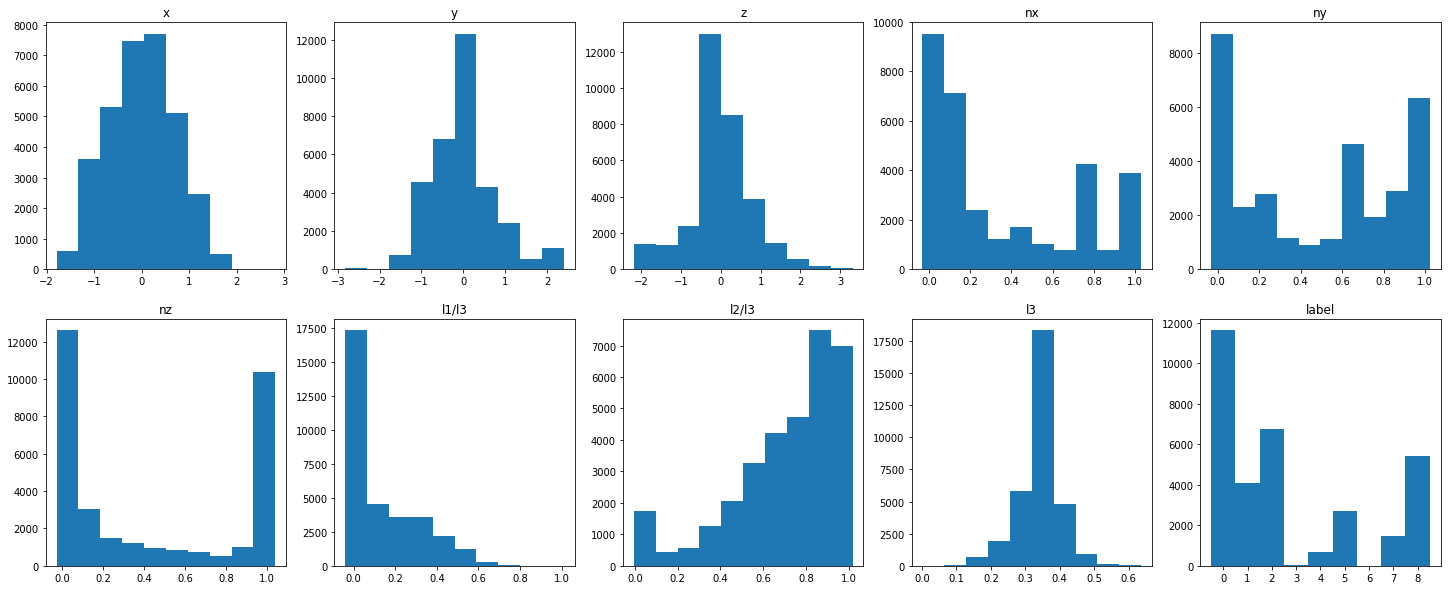

In [2]:
training_dataset = NPM3DGenerator_full(paths_to_keep = [0, 1, 2, 3], sample_uniformly_from_classes = True,
                                       use_reflectance = False)
#validation_dataset = NPM3DGenerator_full(paths_to_keep = [0], sample_uniformly_from_classes = False,
                                        # use_reflectance = False, evaluation = True).get_data()

print(training_dataset)
training_dataset.show_samples()

In [ ]:
miou_metric = u_t.mIoU(training_dataset.n_classes)

#model = build_point_net(input_shape = (training_dataset.n_points, training_dataset.n_channels),
#                        output_shape = training_dataset.n_classes)
#start_model = 13
model = load_model("models/finetunedalllayers_{}_{}_{}_uniform_3e_alldata5e_noise11e".format(training_dataset.n_points, training_dataset.n_channels, training_dataset.n_classes))
model.compile("adam", u_t.my_categorical_crossentropy, metrics = ["accuracy", miou_metric.miou])
model.summary()

Loaded model from disk
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_features (InputLayer)     (None, 4096, 9)      0                                            
__________________________________________________________________________________________________
T_net_3 (Model)                 (None, 9, 9)         817920      input_features[0][0]             
__________________________________________________________________________________________________
transformed3 (Lambda)           (None, 4096, 9)      0           input_features[0][0]             
                                                                 T_net_3[1][0]                    
__________________________________________________________________________________________________
conv10 (Conv1D)                 (None, 4096, 64)     640         transformed3[0][0]   

In [ ]:
n_epochs = 3
for i in range(n_epochs):
    history = model.fit_generator(training_dataset, epochs = 1,
                                  #validation_data = validation_dataset,
                                  class_weight = training_dataset.class_weight,
                                  verbose = 0, callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=True)])
    save_model(model, "models/finetunedalllayers_{}_{}_{}_uniform_3e_alldata5e_noise11e_testclass{}e".format(training_dataset.n_points, training_dataset.n_channels, training_dataset.n_classes, i+1))


Saved model to disk



Saved model to disk


In [ ]:
test_dataset = NPM3DGenerator_full(input_dir = "../Benchmark/test_10_classes_subsampled_2", train = False, use_reflectance = False)
print(test_dataset)
test_dataset.show_samples()
model = load_model("models/finetunedalllayers_4096_9_9_uniform_3e_alldata5e_noise11e_testclass2e")

In [ ]:
for d in range(3):
    for i in range(25):
        plt.hist(test_dataset.sample_point_cloud(d)[0][:, 0], alpha = .1, color = 'b')
    plt.show()

In [ ]:
probas, predictions = test_dataset.predict_point_cloud(model, index = 0)
probas, predictions = test_dataset.predict_point_cloud(model, index = 1)
probas, predictions = test_dataset.predict_point_cloud(model, index = 2)

In [ ]:
probas, predictions = test_dataset.predict_point_cloud(model, index = 2)